In [1]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

%pylab inline

## Data: attractiveness vs. wage

For 1260 study subjects the following variables are measured:

* hourly wage, $
* work experience, years
* education, years
* attractiveness on scale from 1 to 5 (scored by other participants)
* binary features: gender (m/f), marital status (married/not married), health (good/not good), union membership (yes/no), race (black/non-black), employment in service industry (yes/no)

We want to estimate salary differences between people with different levels of attractiveness, while accounting for differences in other features. 

Hamermesh D.S., Biddle J.E. (1994) Beauty and the Labor Market, American Economic Review, 84, 1174–1194.

In [ ]:
raw = pd.read_csv("wages.csv", sep=";", index_col=False) 
raw.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4
3,11.57,38,0,1,0,0,1,1,16,3
4,11.42,27,0,1,0,0,1,0,16,3


Scatterplot matrix for continious features:

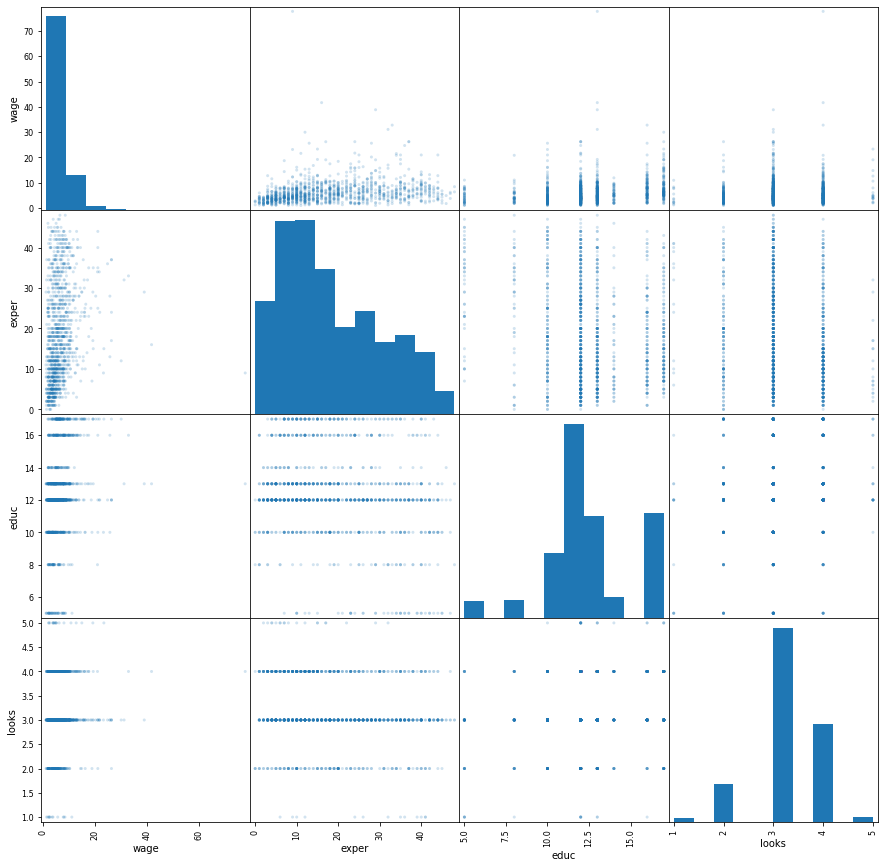

In [ ]:
pd.plotting.scatter_matrix(raw[['wage', 'exper', 'educ', 'looks']], alpha=0.2, 
                                 figsize=(15, 15), diagonal='hist');

Checking whether sample is well balanced on binary features:

In [ ]:
print(raw.union.value_counts())
print(raw.goodhlth.value_counts())
print(raw.black.value_counts())
print(raw.female.value_counts())
print(raw.married.value_counts())
print(raw.service.value_counts())

0    917
1    343
Name: union, dtype: int64
1    1176
0      84
Name: goodhlth, dtype: int64
0    1167
1      93
Name: black, dtype: int64
0    824
1    436
Name: female, dtype: int64
1    871
0    389
Name: married, dtype: int64
0    915
1    345
Name: service, dtype: int64


Every feature has enough samples with each of the values, so we're good here. 

## Preprocessing

In [ ]:
data = raw.copy()

Let's take a look at the target variable distribution:

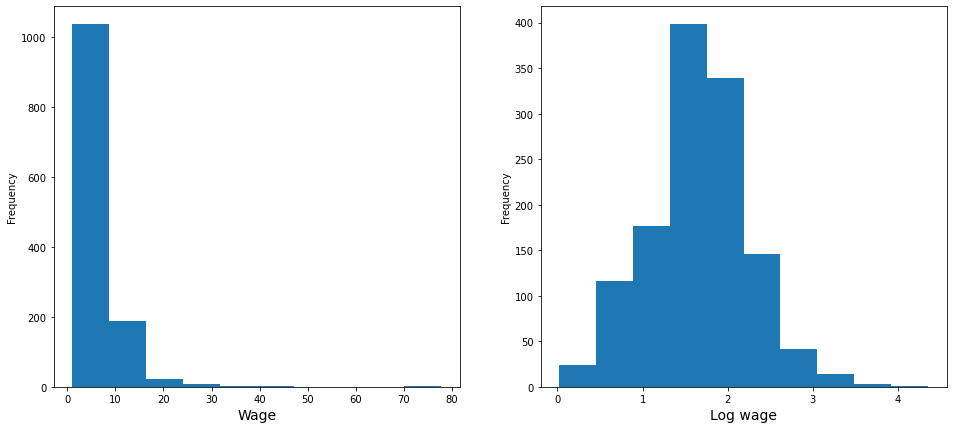

In [ ]:
plt.figure(figsize(16,7))
plt.subplot(121)
data['wage'].plot.hist()
plt.xlabel('Wage', fontsize=14)

plt.subplot(122)
np.log(data['wage']).plot.hist()
plt.xlabel('Log wage', fontsize=14);

One person in the sample gets 77.72 dollars an hour, all the rest  — less than 45 dollars; it would be better if we remove that person from the sample because regression tends to overfit to outliers. Since we want to build a model of mean salary, it would be more stable if we focus on areas of the wage distribution that have good coverage in our sample. 

In [ ]:
data = data[data['wage'] < 77]

Let's take a look at the distribution of attractiveness scores:

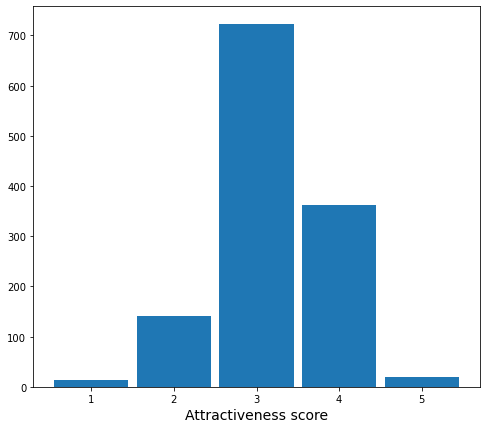

In [ ]:
plt.figure(figsize(8,7))
data.groupby('looks')['looks'].agg(lambda x: len(x)).plot(kind='bar', width=0.9)
plt.xticks(rotation=0)
plt.xlabel('Attractiveness score', fontsize=14);

There are very few observations with looks=1 and looks=5. Let's turn this feature into a categorical one and encode it with two binary variables: one would be 1 if the person's attractiveness score is above average (>3), and another – if it's below average (<3).

In [ ]:
data['belowavg'] = (data.looks < 3).astype(int)
data['aboveavg'] = (data.looks > 3).astype(int)
data.drop('looks', axis=1, inplace=True)

Data now:

In [ ]:
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
0,5.73,30,0,1,0,1,1,1,14,0,1
1,4.28,28,0,1,0,1,1,0,12,0,0
2,7.96,35,0,1,0,1,0,0,10,0,1
3,11.57,38,0,1,0,0,1,1,16,0,0
4,11.42,27,0,1,0,0,1,0,16,0,0


## Building a model

### Version 1
Linear regression model on all features:

In [ ]:
m1 = smf.ols('wage ~ exper + union + goodhlth + black + female + married +'\
                    'service + educ + belowavg + aboveavg', 
             data=data)
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     44.31
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           1.42e-75
Time:                        13:55:42   Log-Likelihood:                -3402.9
No. Observations:                1259   AIC:                             6828.
Df Residuals:                    1248   BIC:                             6884.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5898      0.743     -0.793      0.4



Overall $R^2$ is quite low – the model is not great, which might indicate both that the model is bad or that the prediction problem is difficult.

Let's take a loot at the distribution of residuals:

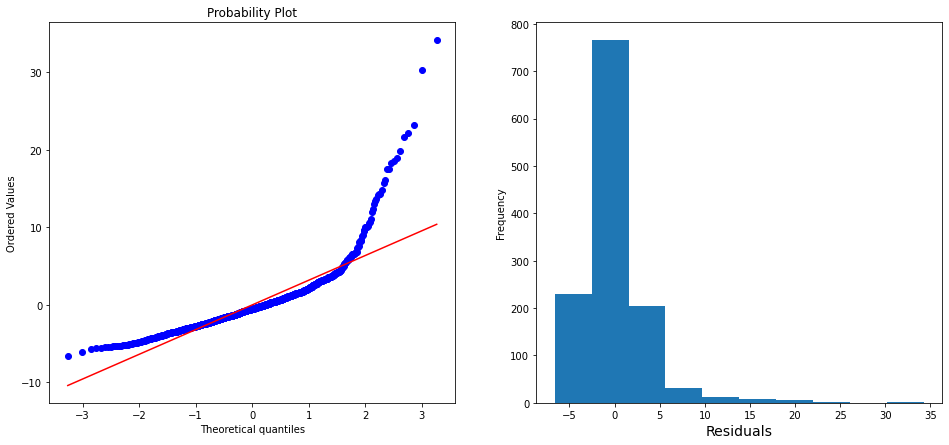

In [ ]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14);

It is quite skewed, just like the target variable itself. It means that the assumption of gaussian noise is far from truth in this model, and as a result of that we can't trust statistical tests for the significance of the coefficients. In situations like this sometimes it helps to build regression model for the log of the target variable instead. 

### Version 2 – log wage target

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     77.63
Date:                Sun, 13 Dec 2020   Prob (F-statistic):          1.18e-123
Time:                        13:55:43   Log-Likelihood:                -816.90
No. Observations:                1259   AIC:                             1656.
Df Residuals:                    1248   BIC:                             1712.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4515      0.095      4.737      0.0

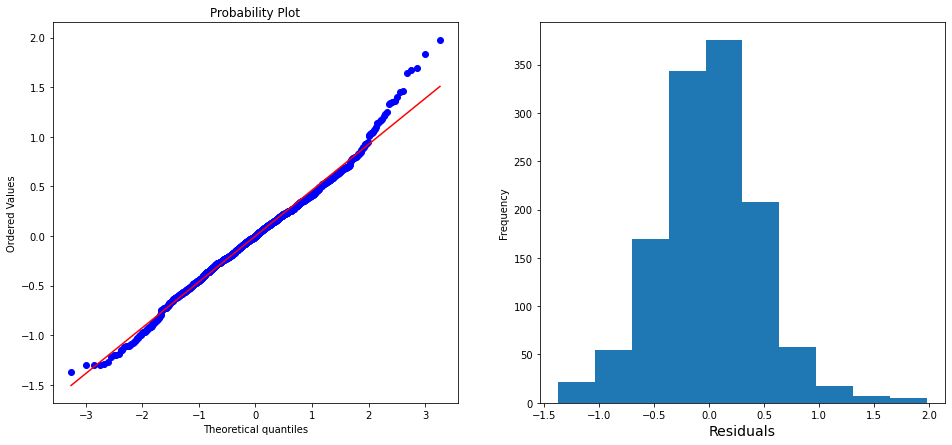

In [ ]:
m2 = smf.ols('np.log(wage) ~ exper + union + goodhlth + black + female + married +'\
                            'service + educ + belowavg + aboveavg', data=data)
fitted = m2.fit()
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14);

Looks better! 

Let's look at residuals vs. continious features:

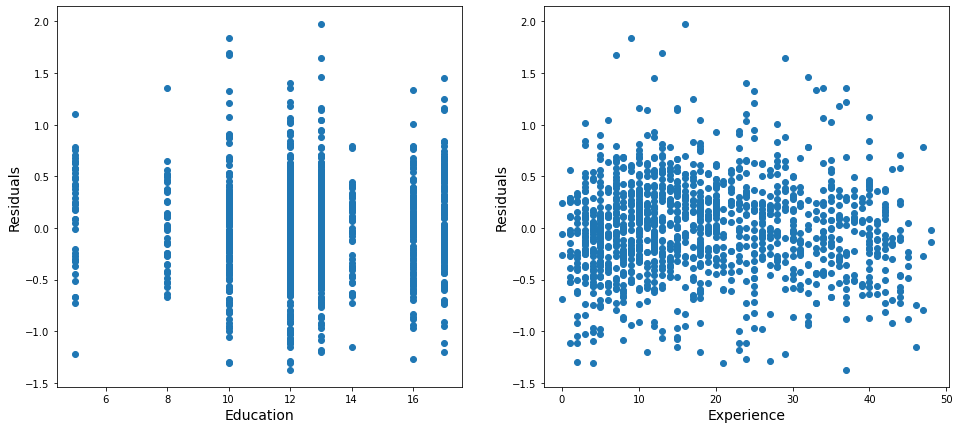

In [ ]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(data['educ'],fitted.resid)
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
scatter(data['exper'],fitted.resid)
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14);

On the right plot you might spot a quadratic dependence of the residuals on the work experience variable. It suggests a potential quadratic dependence of the target on work experience as well. Let's add it into the model.

### Version 3 – with squared work experience

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     76.46
Date:                Sun, 13 Dec 2020   Prob (F-statistic):          3.19e-131
Time:                        13:55:43   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3424      0

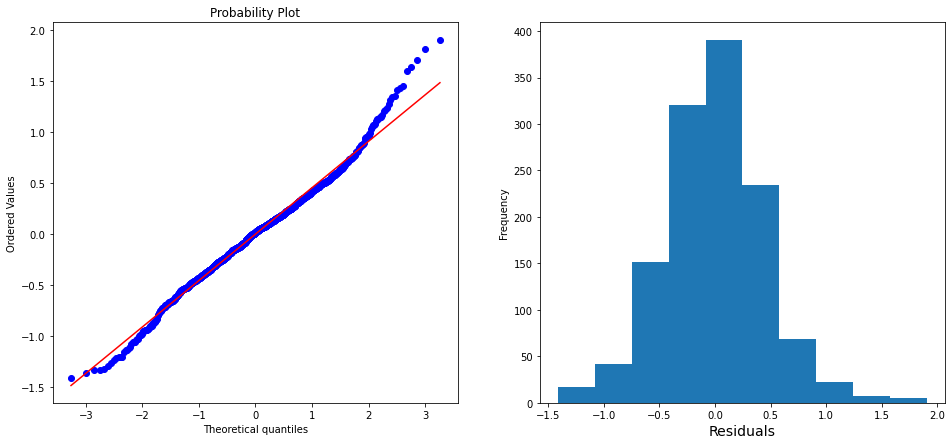

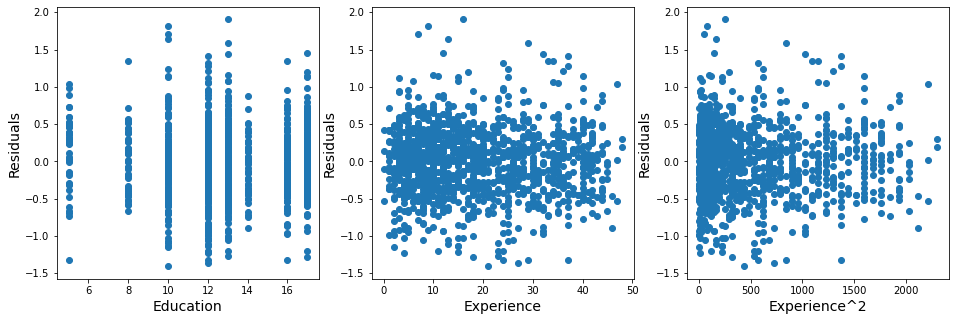

In [ ]:
m3 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'\
                            'married + service + educ + belowavg + aboveavg', data=data)
fitted = m3.fit()
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.figure(figsize(16,5))
plt.subplot(131)
scatter(data['educ'],fitted.resid)
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(132)
scatter(data['exper'],fitted.resid)
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(133)
scatter(data['exper']**2,fitted.resid)
plt.xlabel('Experience^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14);

We might want to exclude some unimportant features to reduce the variance of the estimates. But, before looking at features' significance in the model, let's make sure the error is homoscedastic – otherwise p-values might be incorrect for t tests.

Breusch-Pagan test for homoscedasticity:

In [ ]:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000004


The error is heteroscedastic! We can adjust for that by using White's correction for heteroscedasticity – it is done by providing cov_type parameter for the fit(). There are several types of White's correction (and it's not very clear if any of those types are better than others); we are going to use type 1  – cov_type='HC1'.

### Version 4 – with tests adjusted for heteroscedasticity

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     87.29
Date:                Sun, 13 Dec 2020   Prob (F-statistic):          4.23e-146
Time:                        13:55:44   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3424      0

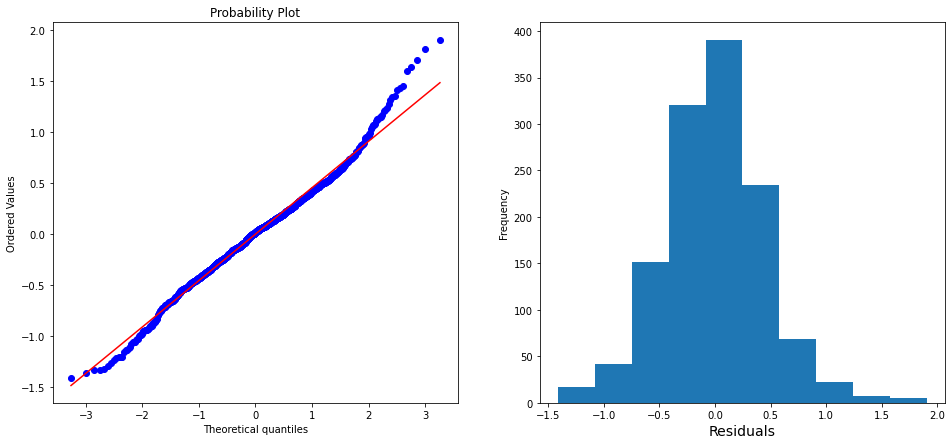

In [ ]:
m4 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'\
                            'married + service + educ + belowavg + aboveavg', data=data)
fitted = m4.fit(cov_type='HC1')
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14);

### Version 5 – without some unimportant predictors

P>|z| column in the output of the model summary contains p-values for all features. In the previous model, the following features are not significant (have p-values > 0.05): race, health, martial status – let's try to remove them. The indicator of the attractiveness above average is not significant too, but we are going to keep it in the model because we want to draw conclusions about it in the end – it's the main question of the study whether differences in attractiveness are associated with differences in wages. 

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     121.1
Date:                Sun, 13 Dec 2020   Prob (F-statistic):          6.49e-150
Time:                        13:55:44   Log-Likelihood:                -799.30
No. Observations:                1259   AIC:                             1617.
Df Residuals:                    1250   BIC:                             1663.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3906      0

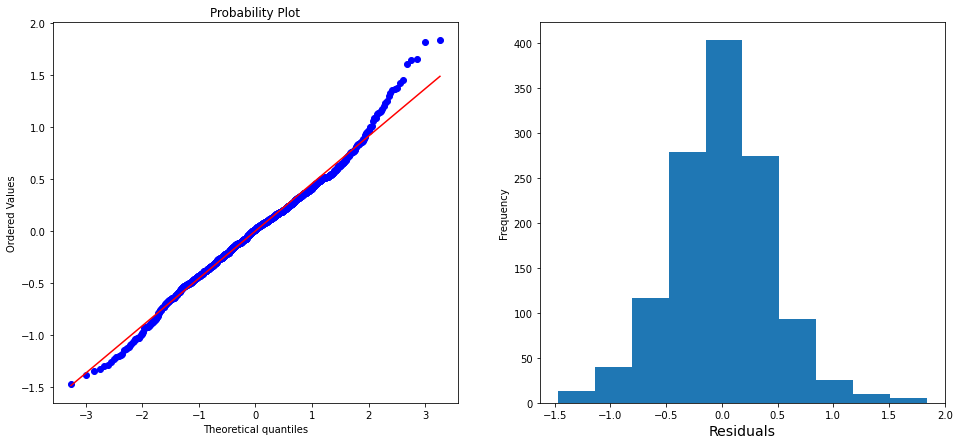

In [ ]:
m5 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + female + service + educ +'\
                            'belowavg + aboveavg', data=data)
fitted = m5.fit(cov_type='HC1')
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14);

Has the model become worse after 3 features were removed? Let's check it with Fisher's test:

In [ ]:
print("Fisher's test comparing models 5 and 4: F=%f, p=%f, k1=%f" % m4.fit().compare_f_test(m5.fit()))

Fisher's test comparing models 5 and 4: F=1.611478, p=0.184911, k1=3.000000


The difference between models 5 (which is smaller) and 4 (larger) is not significant, which means that removing those 3 features from was justified. 

For the final check, let's see if some of the rows in the dataset have disproportionally large influence on the estimates of the coefficients. We could quantify that with a quantity called leverage. To calculate it for every observation in the sample, we compare the full regression model and the one that is build on the sample with that one observation left out. Leverage of the observation is a measure that difference, hence it determines how much influence the observation have on the estimated regression equation. 

Let's plot it against squared residuals:

<Figure size 576x504 with 0 Axes>

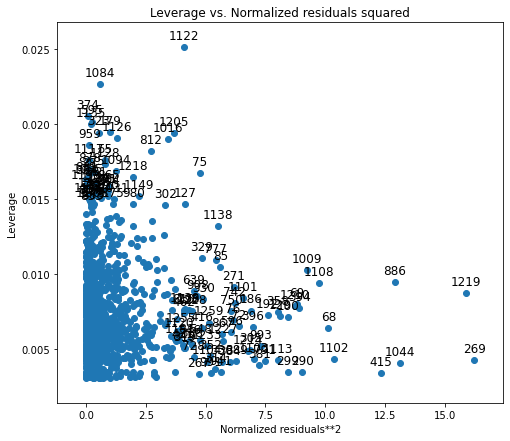

In [ ]:
plt.figure(figsize(8,7))
plot_leverage_resid2(fitted);

There are no points with very different leverage from the rest, which means that there are no obvious problems. Let's examine a couple of datapoints that stand out:

In [ ]:
data.loc[[1122]]

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
1122,6.25,47,0,0,1,1,1,0,5,0,1


This datapoint probably has larger leverage because of the very high work experience – one of the highest in the dataset; there isn't anything that is obviously wrong with this observation.

Observation with the highest residual:

In [ ]:
data.loc[[269]]

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
269,41.67,16,0,0,0,0,1,0,13,0,1


This person has one of the highest wages in the sample; it makes sense that prediction for him would be less accurate – regression works best in the middle of the target's distribution.

## Conclusions
The final model explains 40% of the log wage variance (as indicated by $R^2$). 

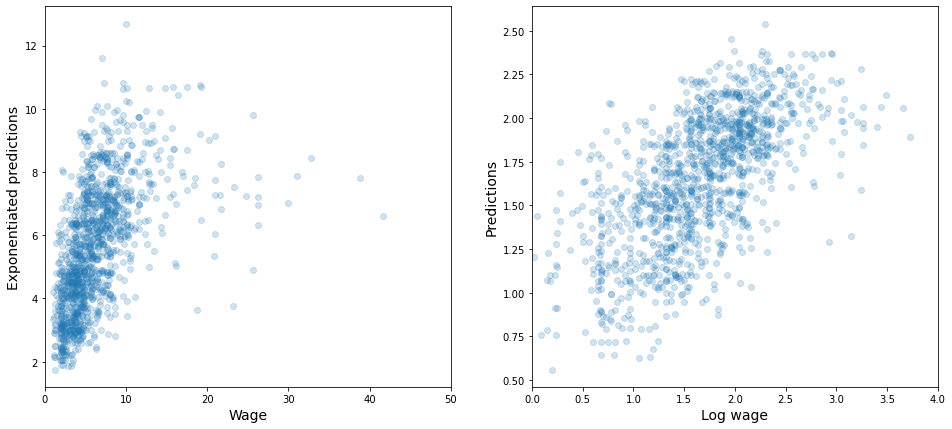

In [ ]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(data['wage'],np.exp(fitted.fittedvalues), alpha=0.2)
plt.xlabel('Wage', fontsize=14)
plt.ylabel('Exponentiated predictions', fontsize=14)
plt.xlim([0,50])

plt.subplot(122)
scatter(np.log(data['wage']),fitted.fittedvalues, alpha=0.2)
plt.xlabel('Log wage', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xlim([0,4]);

The features we are interested in – attractiveness below and above average – have coefficients -0.1307 and -0.0010 respectively. 

Because the regression was run for the logarithm of the wage, the coefficients might be interpreted as percentage differences with the base level. Adjusting for work experience, education level, gender, union membership and tye of the industry a person works in (service or not), a person has:

* 13% lower salary if their attractiveness is below average (p=0.001, 95% confidence interval — [5,21]%);
* the same salary if their attractiveness is above average (p=0.972, 95% confidence interval — [-6,6]%).